In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [3]:
import tensorflow as tf
import numpy as np
import warnings

from tflearn.layers.core import fully_connected, dropout
from tflearn.layers.conv import conv_1d, avg_pool_1d, highway_conv_1d
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.core import fully_connected

from tf_lab.fundamentals.layers import conv_1d_tranpose
from tf_lab.fundamentals.utils import expand_scope_by_name, replicate_parameter_for_all_layers

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
dropout = tf.nn.dropout
# from tflearn.layers.core import fully_connected, dropout


In [6]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
# experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
loss = 'chamfer'
n_pc_points = 2048
random_seed = 42
# bneck_list = [128]
class_name = raw_input('Give me the class type: ').lower()

Give me the class type: chair


In [7]:
syn_id = snc_category_to_synth_id()[class_name]
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1, n_pc_points=2048)

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [8]:
def adaptive_hierarchical_encoder(in_signal, n_filters=[64, 128, 256, 1024], filter_sizes=[1], strides=[1],
                                        b_norm=True, spn=False, non_linearity=tf.nn.relu, regularizer=None, weight_decay=0.001,
                                        symmetry=tf.reduce_max, dropout_prob=None, pool=avg_pool_1d, pool_sizes=None, scope=None,
                                        reuse=False, padding='same', verbose=False, closing=None, conv_op=conv_1d):
    '''An Encoder (recognition network), which maps inputs onto a latent space.
    '''

    if verbose:
        print 'Building Encoder'

    n_pc_points = int(in_signal.shape[1])
    batch_size = tf.shape(in_signal)[0]
    
#     with tf.name_scope("coupling_weights"):
#         W_couple = tf.random_normal(shape=(1, n_pc_points, n_pc_points), stddev=0.0001, dtype=tf.float32, name="W_coupling")        
#         W = tf.Variable(W_couple, name="W_couple")
#         coupler = tf.nn.softmax(W, dim=2, name="soft-max-coupling")
#         coupler = tf.tile(coupler, [batch_size, 1, 1])
    

    
    n_layers = len(n_filters)
    filter_sizes = replicate_parameter_for_all_layers(filter_sizes, n_layers)
    strides = replicate_parameter_for_all_layers(strides, n_layers)
#     dropout_prob = replicate_parameter_for_all_layers(dropout_prob, n_layers)

    if n_layers < 2:
        raise ValueError('More than 1 layers are expected.')

    if spn:
        transformer = pcloud_spn(in_signal)
        in_signal = tf.batch_matmul(in_signal, transformer)
        print 'Spatial transformer was activated.'
    
    codes = []
    for i in xrange(n_layers):
        if i == 0:
            layer = in_signal

        name = 'encoder_conv_layer_' + str(i)
        scope_i = expand_scope_by_name(scope, name)
        layer = conv_op(layer, nb_filter=n_filters[i], filter_size=filter_sizes[i], strides=strides[i], regularizer=regularizer,
                        weight_decay=weight_decay, name=name, reuse=reuse, scope=scope_i, padding=padding)
        
        if verbose:
            print name, 'conv params = ', np.prod(layer.W.get_shape().as_list()) + np.prod(layer.b.get_shape().as_list()),

        if b_norm:
            name += '_bnorm'
            scope_i = expand_scope_by_name(scope, name)
            layer = batch_normalization(layer, name=name, reuse=reuse, scope=scope_i)
            if verbose:
                print 'bnorm params = ', np.prod(layer.beta.get_shape().as_list()) + np.prod(layer.gamma.get_shape().as_list())

        
            layer = layer - tf.reduce_mean(layer, axis=[1], keep_dims=True)
            cov_layer_i = tf.matmul(layer, layer, transpose_b=True)            
            cov_layer_i = tf.nn.softmax(cov_layer_i, dim=1, name="soft-max-coupling")            
            cov_layer_i = tf.matrix_set_diag(cov_layer_i, tf.zeros(shape=(batch_size, n_pc_points)))                    
            layer = tf.matmul(cov_layer_i, layer)
            
            
        if non_linearity is not None:
            layer = non_linearity(layer)

        if pool is not None and pool_sizes is not None:
            if pool_sizes[i] is not None:
                layer = pool(layer, kernel_size=pool_sizes[i])

#         layer = tf.matmul(coupler, layer)
        codes.append(tf.reduce_max(layer, axis=1))
        
        if dropout_prob is not None and dropout_prob[i] != 0:
            layer = dropout(layer, 1.0 - dropout_prob[i])

        if verbose:
            print layer
            print 'output size:', np.prod(layer.get_shape().as_list()[1:]), '\n'

#     if symmetry is not None:
#         layer = symmetry(layer, axis=1)
#         if verbose:
#             print layer

#     if closing is not None:
#         layer = closing(layer)
#         print layer

    return tf.concat(codes, axis=1)

In [9]:
conv_op = conv_1d
n_filters = [32, 64, 64]
filter_sizes = [1]
strides = [1]
bneck = 128
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck)

enc_args = {'n_filters': n_filters}
# in_signal = tf.placeholder(tf.float32, shape=(None, 2048, 3))

In [ ]:
# Try 32-32-32-32: to also be de-corelated

In [10]:
train_params = default_train_params()
# experiment_id = '_'.join(['ae', class_name, experiment_tag, str(n_pc_points), 'pts', str(bneck), 'bneck', loss])
experiment_id = '1'
train_dir = osp.join(top_data_dir, 'OUT/temp/', experiment_id)
create_dir(train_dir)

reset_tf_graph()

conf = Conf(n_input = [n_pc_points, 3],
            loss = loss,
            training_epochs = 500,
            batch_size = train_params['batch_size'],
            denoising = False,
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = train_params['saver_step'],
            z_rotate = False,
            encoder = adaptive_hierarchical_encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
print conf
conf.experiment_name = 'experiment_' + str(experiment_id)
conf.held_out_step = 5
conf.save(osp.join(train_dir, 'configuration'))
ae = PointNetAutoEncoder(conf.experiment_name, conf)

                    batch_size: 50
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'b_norm_finish': False, 'verbose': True, 'b_norm': False, 'layer_sizes': [256, 256, 6144]}
                       encoder: adaptive_hierarchical_encoder
                  encoder_args: {'n_filters': [32, 64, 64]}
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: chamfer
             loss_display_step: 1
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/optas/DATA/OUT/temp/1
               training_epochs: 500
                      z_rotate: False

Building Decoder
decode

In [11]:
buf_size = 1 # flush each line
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(in_data['train'], conf, log_file=fout, held_out_data=in_data['val'])
fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.7761', 'loss=', '4.347228478')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.


('Epoch:', '0002', 'training time (minutes)=', '0.7839', 'loss=', '0.009512041')
('Epoch:', '0003', 'training time (minutes)=', '0.7812', 'loss=', '0.005312244')
('Epoch:', '0004', 'training time (minutes)=', '0.7843', 'loss=', '0.004636527')
('Epoch:', '0005', 'training time (minutes)=', '0.7840', 'loss=', '0.004290106')
('Held Out Data :', 'forward time (minutes)=', '0.0187', 'loss=', '0.004317523')
('Epoch:', '0006', 'training time (minutes)=', '0.7868', 'loss=', '0.004175481')
('Epoch:', '0007', 'training time (minutes)=', '0.7852', 'loss=', '0.004079544')
('Epoch:', '0008', 'training time (minutes)=', '0.7845', 'loss=', '0.003960764')
('Epoch:', '0009', 'training time (minutes)=', '0.7819', 'loss=', '0.003927543')
('Epoch:', '0010', 'training time (minutes)=', '0.7834', 'loss=', '0.003848095')
INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003835957')
('Epoch:', '0011', 'training time (minutes)=', '0.7819', 'loss=', '0.003789509')
('Epoch:', '0012', 'training time (minutes)=', '0.7816', 'loss=', '0.003805181')
('Epoch:', '0013', 'training time (minutes)=', '0.7846', 'loss=', '0.003722762')
('Epoch:', '0014', 'training time (minutes)=', '0.7810', 'loss=', '0.003672824')
('Epoch:', '0015', 'training time (minutes)=', '0.7837', 'loss=', '0.003637800')
('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003697135')
('Epoch:', '0016', 'training time (minutes)=', '0.7795', 'loss=', '0.003616723')
('Epoch:', '0017', 'training time (minutes)=', '0.7856', 'loss=', '0.003591503')
('Epoch:', '0018', 'training time (minutes)=', '0.7827', 'loss=', '0.003585057')
('Epoch:', '0019', 'training time (minutes)=', '0.7846', 'loss=', '0.003563007')
('Epoch:', '0020', 'training time (minutes)=', '0.7803', 'loss=', '0.003512099')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-20 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003638299')
('Epoch:', '0021', 'training time (minutes)=', '0.7821', 'loss=', '0.003475786')
('Epoch:', '0022', 'training time (minutes)=', '0.7809', 'loss=', '0.003470645')
('Epoch:', '0023', 'training time (minutes)=', '0.7841', 'loss=', '0.003439170')
('Epoch:', '0024', 'training time (minutes)=', '0.7818', 'loss=', '0.003470088')
('Epoch:', '0025', 'training time (minutes)=', '0.7817', 'loss=', '0.003472187')
('Held Out Data :', 'forward time (minutes)=', '0.0180', 'loss=', '0.003591115')
('Epoch:', '0026', 'training time (minutes)=', '0.7816', 'loss=', '0.003414142')
('Epoch:', '0027', 'training time (minutes)=', '0.7838', 'loss=', '0.003364596')
('Epoch:', '0028', 'training time (minutes)=', '0.7819', 'loss=', '0.003377361')
('Epoch:', '0029', 'training time (minutes)=', '0.7808', 'loss=', '0.003338949')
('Epoch:', '0030', 'training time (minutes)=', '0.7859', 'loss=', '0.003314152')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-30 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0180', 'loss=', '0.003380155')
('Epoch:', '0031', 'training time (minutes)=', '0.7855', 'loss=', '0.003293955')
('Epoch:', '0032', 'training time (minutes)=', '0.7868', 'loss=', '0.003299148')
('Epoch:', '0033', 'training time (minutes)=', '0.7803', 'loss=', '0.003289762')
('Epoch:', '0034', 'training time (minutes)=', '0.7819', 'loss=', '0.003254069')
('Epoch:', '0035', 'training time (minutes)=', '0.7808', 'loss=', '0.003234351')
('Held Out Data :', 'forward time (minutes)=', '0.0186', 'loss=', '0.003458057')
('Epoch:', '0036', 'training time (minutes)=', '0.7831', 'loss=', '0.003237688')
('Epoch:', '0037', 'training time (minutes)=', '0.7789', 'loss=', '0.003226528')
('Epoch:', '0038', 'training time (minutes)=', '0.7800', 'loss=', '0.003199252')
('Epoch:', '0039', 'training time (minutes)=', '0.7821', 'loss=', '0.003184653')
('Epoch:', '0040', 'training time (minutes)=', '0.7819', 'loss=', '0.003164813')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-40 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0180', 'loss=', '0.003396996')
('Epoch:', '0041', 'training time (minutes)=', '0.7811', 'loss=', '0.003179506')
('Epoch:', '0042', 'training time (minutes)=', '0.7818', 'loss=', '0.003144486')
('Epoch:', '0043', 'training time (minutes)=', '0.7829', 'loss=', '0.003158143')
('Epoch:', '0044', 'training time (minutes)=', '0.7801', 'loss=', '0.003139580')
('Epoch:', '0045', 'training time (minutes)=', '0.7793', 'loss=', '0.003111395')
('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003069802')
('Epoch:', '0046', 'training time (minutes)=', '0.7831', 'loss=', '0.003085191')
('Epoch:', '0047', 'training time (minutes)=', '0.7778', 'loss=', '0.003075235')
('Epoch:', '0048', 'training time (minutes)=', '0.7806', 'loss=', '0.003077216')
('Epoch:', '0049', 'training time (minutes)=', '0.7820', 'loss=', '0.003047635')
('Epoch:', '0050', 'training time (minutes)=', '0.7820', 'loss=', '0.003096034')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-50 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003320772')
('Epoch:', '0051', 'training time (minutes)=', '0.7795', 'loss=', '0.003055434')
('Epoch:', '0052', 'training time (minutes)=', '0.7848', 'loss=', '0.003049682')
('Epoch:', '0053', 'training time (minutes)=', '0.7813', 'loss=', '0.003033042')
('Epoch:', '0054', 'training time (minutes)=', '0.7829', 'loss=', '0.003043311')
('Epoch:', '0055', 'training time (minutes)=', '0.7814', 'loss=', '0.003037758')
('Held Out Data :', 'forward time (minutes)=', '0.0185', 'loss=', '0.003223051')
('Epoch:', '0056', 'training time (minutes)=', '0.7810', 'loss=', '0.003040259')
('Epoch:', '0057', 'training time (minutes)=', '0.7831', 'loss=', '0.003003834')
('Epoch:', '0058', 'training time (minutes)=', '0.7819', 'loss=', '0.003025718')
('Epoch:', '0059', 'training time (minutes)=', '0.7799', 'loss=', '0.002998102')
('Epoch:', '0060', 'training time (minutes)=', '0.7785', 'loss=', '0.002998212')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-60 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003246646')
('Epoch:', '0061', 'training time (minutes)=', '0.7809', 'loss=', '0.002990812')
('Epoch:', '0062', 'training time (minutes)=', '0.7809', 'loss=', '0.002999230')
('Epoch:', '0063', 'training time (minutes)=', '0.7866', 'loss=', '0.002988516')
('Epoch:', '0064', 'training time (minutes)=', '0.7815', 'loss=', '0.002988762')
('Epoch:', '0065', 'training time (minutes)=', '0.7794', 'loss=', '0.002982031')
('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003059974')
('Epoch:', '0066', 'training time (minutes)=', '0.7830', 'loss=', '0.002962818')
('Epoch:', '0067', 'training time (minutes)=', '0.7855', 'loss=', '0.002940032')
('Epoch:', '0068', 'training time (minutes)=', '0.7841', 'loss=', '0.002954932')
('Epoch:', '0069', 'training time (minutes)=', '0.7824', 'loss=', '0.002955107')
('Epoch:', '0070', 'training time (minutes)=', '0.7808', 'loss=', '0.002963833')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-70 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0185', 'loss=', '0.003238136')
('Epoch:', '0071', 'training time (minutes)=', '0.7847', 'loss=', '0.002935405')
('Epoch:', '0072', 'training time (minutes)=', '0.7818', 'loss=', '0.002960563')
('Epoch:', '0073', 'training time (minutes)=', '0.7801', 'loss=', '0.003010393')
('Epoch:', '0074', 'training time (minutes)=', '0.7823', 'loss=', '0.002917455')
('Epoch:', '0075', 'training time (minutes)=', '0.7802', 'loss=', '0.002943933')
('Held Out Data :', 'forward time (minutes)=', '0.0184', 'loss=', '0.003265606')
('Epoch:', '0076', 'training time (minutes)=', '0.7873', 'loss=', '0.002945900')
('Epoch:', '0077', 'training time (minutes)=', '0.7840', 'loss=', '0.002928250')
('Epoch:', '0078', 'training time (minutes)=', '0.7846', 'loss=', '0.002923530')
('Epoch:', '0079', 'training time (minutes)=', '0.7833', 'loss=', '0.002914809')
('Epoch:', '0080', 'training time (minutes)=', '0.7832', 'loss=', '0.002940385')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-80 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0185', 'loss=', '0.003230557')
('Epoch:', '0081', 'training time (minutes)=', '0.7818', 'loss=', '0.002922130')
('Epoch:', '0082', 'training time (minutes)=', '0.7800', 'loss=', '0.003004718')
('Epoch:', '0083', 'training time (minutes)=', '0.7835', 'loss=', '0.002934772')
('Epoch:', '0084', 'training time (minutes)=', '0.7820', 'loss=', '0.002897792')
('Epoch:', '0085', 'training time (minutes)=', '0.7808', 'loss=', '0.002905121')
('Held Out Data :', 'forward time (minutes)=', '0.0180', 'loss=', '0.002937309')
('Epoch:', '0086', 'training time (minutes)=', '0.7816', 'loss=', '0.002913567')
('Epoch:', '0087', 'training time (minutes)=', '0.7829', 'loss=', '0.002983211')
('Epoch:', '0088', 'training time (minutes)=', '0.7818', 'loss=', '0.002952285')
('Epoch:', '0089', 'training time (minutes)=', '0.7781', 'loss=', '0.002901172')
('Epoch:', '0090', 'training time (minutes)=', '0.7826', 'loss=', '0.002910981')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-90 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0183', 'loss=', '0.003015211')
('Epoch:', '0091', 'training time (minutes)=', '0.7815', 'loss=', '0.002887442')
('Epoch:', '0092', 'training time (minutes)=', '0.7815', 'loss=', '0.002877885')
('Epoch:', '0093', 'training time (minutes)=', '0.7800', 'loss=', '0.002902017')
('Epoch:', '0094', 'training time (minutes)=', '0.7809', 'loss=', '0.002910750')
('Epoch:', '0095', 'training time (minutes)=', '0.7804', 'loss=', '0.002906002')
('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003073532')
('Epoch:', '0096', 'training time (minutes)=', '0.7811', 'loss=', '0.002904551')
('Epoch:', '0097', 'training time (minutes)=', '0.7812', 'loss=', '0.002876838')
('Epoch:', '0098', 'training time (minutes)=', '0.7818', 'loss=', '0.002929727')
('Epoch:', '0099', 'training time (minutes)=', '0.7800', 'loss=', '0.002898823')
('Epoch:', '0100', 'training time (minutes)=', '0.7817', 'loss=', '0.002882997')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-100 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0182', 'loss=', '0.003063129')
('Epoch:', '0101', 'training time (minutes)=', '0.7822', 'loss=', '0.002872543')
('Epoch:', '0102', 'training time (minutes)=', '0.7857', 'loss=', '0.002909644')
('Epoch:', '0103', 'training time (minutes)=', '0.7836', 'loss=', '0.002868585')
('Epoch:', '0104', 'training time (minutes)=', '0.7851', 'loss=', '0.002890358')
('Epoch:', '0105', 'training time (minutes)=', '0.7847', 'loss=', '0.002927707')
('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003058616')
('Epoch:', '0106', 'training time (minutes)=', '0.7901', 'loss=', '0.002903953')
('Epoch:', '0107', 'training time (minutes)=', '0.7828', 'loss=', '0.003040317')
('Epoch:', '0108', 'training time (minutes)=', '0.7818', 'loss=', '0.002901136')
('Epoch:', '0109', 'training time (minutes)=', '0.7843', 'loss=', '0.002980003')
('Epoch:', '0110', 'training time (minutes)=', '0.7851', 'loss=', '0.002942618')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-110 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003095652')
('Epoch:', '0111', 'training time (minutes)=', '0.7814', 'loss=', '0.002905327')
('Epoch:', '0112', 'training time (minutes)=', '0.7828', 'loss=', '0.002869959')
('Epoch:', '0113', 'training time (minutes)=', '0.7801', 'loss=', '0.002866160')
('Epoch:', '0114', 'training time (minutes)=', '0.7811', 'loss=', '0.002898379')
('Epoch:', '0115', 'training time (minutes)=', '0.7812', 'loss=', '0.002865578')
('Held Out Data :', 'forward time (minutes)=', '0.0183', 'loss=', '0.003038573')
('Epoch:', '0116', 'training time (minutes)=', '0.7830', 'loss=', '0.002875580')
('Epoch:', '0117', 'training time (minutes)=', '0.7796', 'loss=', '0.002877388')
('Epoch:', '0118', 'training time (minutes)=', '0.7827', 'loss=', '0.002876228')
('Epoch:', '0119', 'training time (minutes)=', '0.7830', 'loss=', '0.002865110')
('Epoch:', '0120', 'training time (minutes)=', '0.7844', 'loss=', '0.002877285')
INFO:tensorflow:/orions4-zfs

INFO:tensorflow:/orions4-zfs/projects/optas/DATA/OUT/temp/1/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.


('Held Out Data :', 'forward time (minutes)=', '0.0181', 'loss=', '0.003071233')
('Epoch:', '0121', 'training time (minutes)=', '0.7828', 'loss=', '0.002871649')
('Epoch:', '0122', 'training time (minutes)=', '0.7809', 'loss=', '0.002892002')
('Epoch:', '0123', 'training time (minutes)=', '0.7839', 'loss=', '0.002879017')
('Epoch:', '0124', 'training time (minutes)=', '0.7796', 'loss=', '0.002893978')
('Epoch:', '0125', 'training time (minutes)=', '0.7818', 'loss=', '0.002883885')
('Held Out Data :', 'forward time (minutes)=', '0.0180', 'loss=', '0.002994052')
('Epoch:', '0126', 'training time (minutes)=', '0.7824', 'loss=', '0.002859710')
('Epoch:', '0127', 'training time (minutes)=', '0.7846', 'loss=', '0.002855167')
('Epoch:', '0128', 'training time (minutes)=', '0.7808', 'loss=', '0.002852554')


KeyboardInterrupt: 

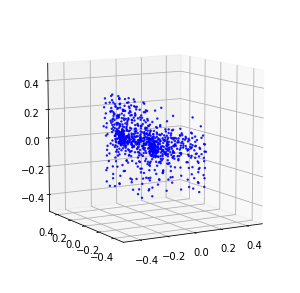

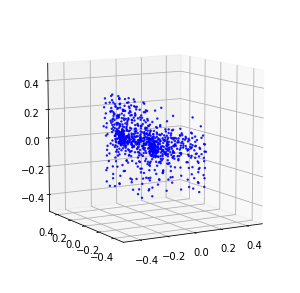

In [15]:
Point_Cloud(ae.reconstruct(in_data['test'].next_batch(1)[0])[0][0]).plot()

In [74]:
g = tf.get_default_graph()
# g.get_all_collection_keys()
v = g.get_collection('trainable_variables')[0]

In [75]:
lala = ae.sess.run(tf.nn.softmax(v, dim=2), feed_dict={ae.x:in_data['train'].next_batch(50)[0]})[0]
np.sum(lala, axis=1)

array([ 1.        ,  1.        ,  0.99999982, ...,  0.99999988,
        1.        ,  0.99999976], dtype=float32)

In [ ]:
plt.plot(lala[:,4])
plt.plot(lala[:,100])

In [ ]:
# out = adaptive_hierarchical_encoder(in_signal, n_filters=n_filters, filter_sizes=[1], strides=[1],
#                               b_norm=True, spn=False, non_linearity=tf.nn.relu, regularizer=None, weight_decay=0.001,
#                               symmetry=tf.reduce_max, dropout_prob=None, pool=avg_pool_1d, pool_sizes=None, scope=None,
#                               reuse=False, padding='same', verbose=False, closing=None, conv_op=conv_1d)